In [1]:
import matplotlib.pyplot as plt

import numpy as np
from scipy.signal import convolve

from neurodsp.sim import sim_synaptic_kernel
from neurodsp.spectral import compute_spectrum
from neurodsp.utils.norm import normalize_sig

from timescales.sim import sim_spikes_synaptic, sim_exp_decay, sim_poisson_distribution
from timescales.fit import convert_knee_val

## Poisson Process Estimation

This notebook provides a time domain approach for estimating timescales. The underlying Poisson distribution of spike trains can be estimated. This means that the kernel, and by extension the timescale, can be solved for. This avoids needing to go to frequency space and decreases bias from finite duration time series.

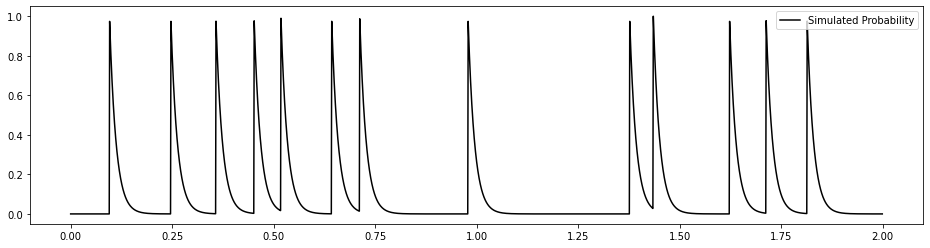

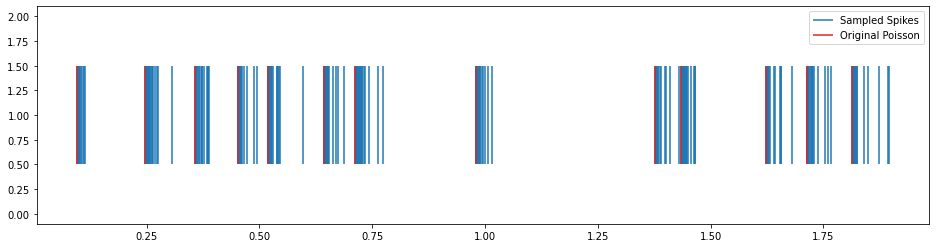

In [2]:
# Simulate
np.random.seed(0)
tau = convert_knee_val(10)
n_seconds = 2
fs = 1000

kernel = sim_synaptic_kernel(10 * tau, fs, 0, tau)
mu = 120

# Pad n_seconds to account for convolution
kern_len = len(kernel[0]) if kernel.ndim == 2 else len(kernel)
times = np.arange(0, int(n_seconds + (kern_len * 2)), 1/fs)

mu = fs * .1  if mu is None else mu
isi = np.round_(np.random.exponential(scale=mu, size=len(times))).astype(int)

# Randomly sample isi's
n_samples = int(n_seconds * fs)
last_ind = np.where(isi.cumsum() >= n_samples)[0]
inds = isi.cumsum() if len(last_ind) == 0 else isi[:last_ind[0]].cumsum()

poisson = np.zeros(len(times), dtype=int)
poisson[inds] = True

probs = convolve(poisson, kernel)[:n_samples]
probs = (probs - np.min(probs)) / np.ptp(probs)

spikes = (probs > np.random.rand(*probs.shape))

poisson = poisson[:n_samples]
times = times[:n_samples]

plt.figure(0, figsize=(16, 4))
plt.plot(times, probs, label='Simulated Probability', color='k')
plt.legend();

plt.figure(1, figsize=(16, 4))
plt.eventplot(times[np.where(spikes)[0]], label='Sampled Spikes', color='C0')
plt.eventplot(times[np.where(poisson)[0]], label='Original Poisson', color='C3')
plt.legend();

### Results

Below, the Poisson process (red above) is estimated from the spike distribution (blue above). An exponential decay window is slide across the spike array to determine where a Poisson point is most likely to occur. The process is:

1. Choose any tau to create an exponentially decay window to slide across the Poisson process. A wide range of tau guess will converge to the same solution.
2. For each window, determine the probability of the observed spikes would be found. De-weight a window's probability if there are immediately preceding spikes or if there few spikes following.
3. Once the Poisson array is estimated, the kernel that most likely produces the true spiking array can be solved for.

In [3]:
# Settings
knee_freq = 10 
pad_ind = 20

xs = np.arange(fs / knee_freq)
kernel_est = np.exp(-xs / (convert_knee_val(knee_freq) * fs))

inds = np.arange(n_samples)

sp_probs = np.zeros(len(spikes))

spikes_pad = np.pad(spikes, (0, 2*len(kernel_est)))

for i in inds:
    
    _spikes = spikes_pad[i:i+len(kernel_est)]
    
    if len(np.where(_spikes)[0]) == 0 or not _spikes[0]:
        continue
    
    # Estimate probabiltity of spikes distribution
    #   within the current window
    _probs = np.zeros(len(_spikes))
    _probs[_spikes] = kernel_est[_spikes]
    _probs[~_spikes] = 1 - kernel_est[~_spikes]
    
    # Weight based on past/future spikes
    sp_probs[i] = _probs.mean()
    
    sp_probs[i] = sp_probs[i] / \
        (((spikes[i-pad_ind:i] * sp_probs[i-pad_ind:i]).sum() + 1))
    
    prev_weights = (sp_probs[i-pad_ind:i] * np.linspace(.1, 1, pad_ind)).sum() + 1
    next_weights = (spikes_pad[i:i+pad_ind] * np.linspace(1, .1, pad_ind)).sum()
    
    sp_probs[i] = sp_probs[i] * next_weights 
    sp_probs[i] = sp_probs[i] / prev_weights 

# Normalize from 0-1
sp_probs = (sp_probs - np.min(sp_probs)) / np.ptp(sp_probs)

# Poisson estimate
poisson_est = np.zeros(len(spikes))
poisson_est[np.where(sp_probs > .25)[0]] = 1

# Spike probability estimate
probs_est = np.convolve(poisson_est, kernel_est)[:len(spikes)]

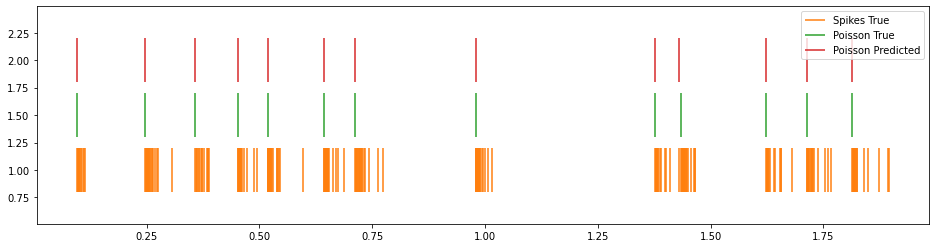

In [4]:
# Plot
plt.figure(figsize=(16, 4))

plt.eventplot(times[np.where(spikes)[0]], color='C1',
              lineoffsets=1, linelengths=.4, label='Spikes True')

plt.eventplot(times[np.where(poisson)[0]], color='C2',
              lineoffsets=1.5, linelengths=.4, label='Poisson True')

plt.eventplot(times[np.where(poisson_est)[0]], color='C3',
              lineoffsets=2, linelengths=.4, label='Poisson Predicted')

plt.legend();

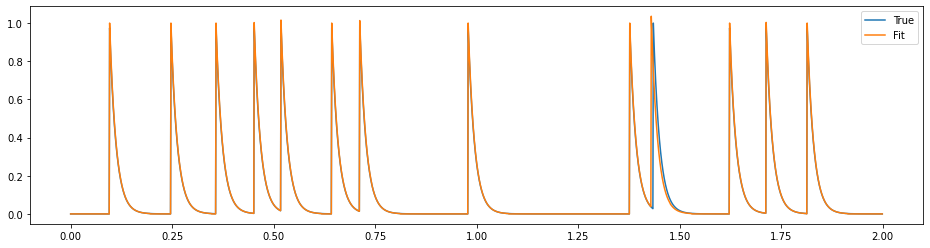

In [5]:
# Plot fit
plt.figure(figsize=(16, 4))

plt.plot(times, probs, label='True')
plt.plot(times, probs_est, label='Fit')
plt.legend();